In [5]:
%pylab inline
import pandas as pd
import requests
from pprint import pprint
from gekkolib.gekkoapi import backtest, plotStats, build_backtest_config

Populating the interactive namespace from numpy and matplotlib


# Config

In [6]:
api = 'http://localhost:3000/api'

# Helpers

In [7]:
get('info')

{'startTime': '2019-01-01 01:59:00', 'endTime': '2019-02-01 00:01:00', 'timespan': 'a month', 'market': -6.928766373326752, 'balance': 3350.16532149, 'profit': -439.52467850999983, 'relativeProfit': -11.597905857998938, 'yearlyProfit': -5192.211783895414, 'relativeYearlyProfit': -137.00887892929015, 'startPrice': 3689.69, 'endPrice': 3434.04, 'trades': 6, 'startBalance': 3789.69, 'exposure': 0.28031085755356905, 'sharpe': -33.98385453416547, 'downside': -8.8882204088967, 'alpha': -432.59591213667306}


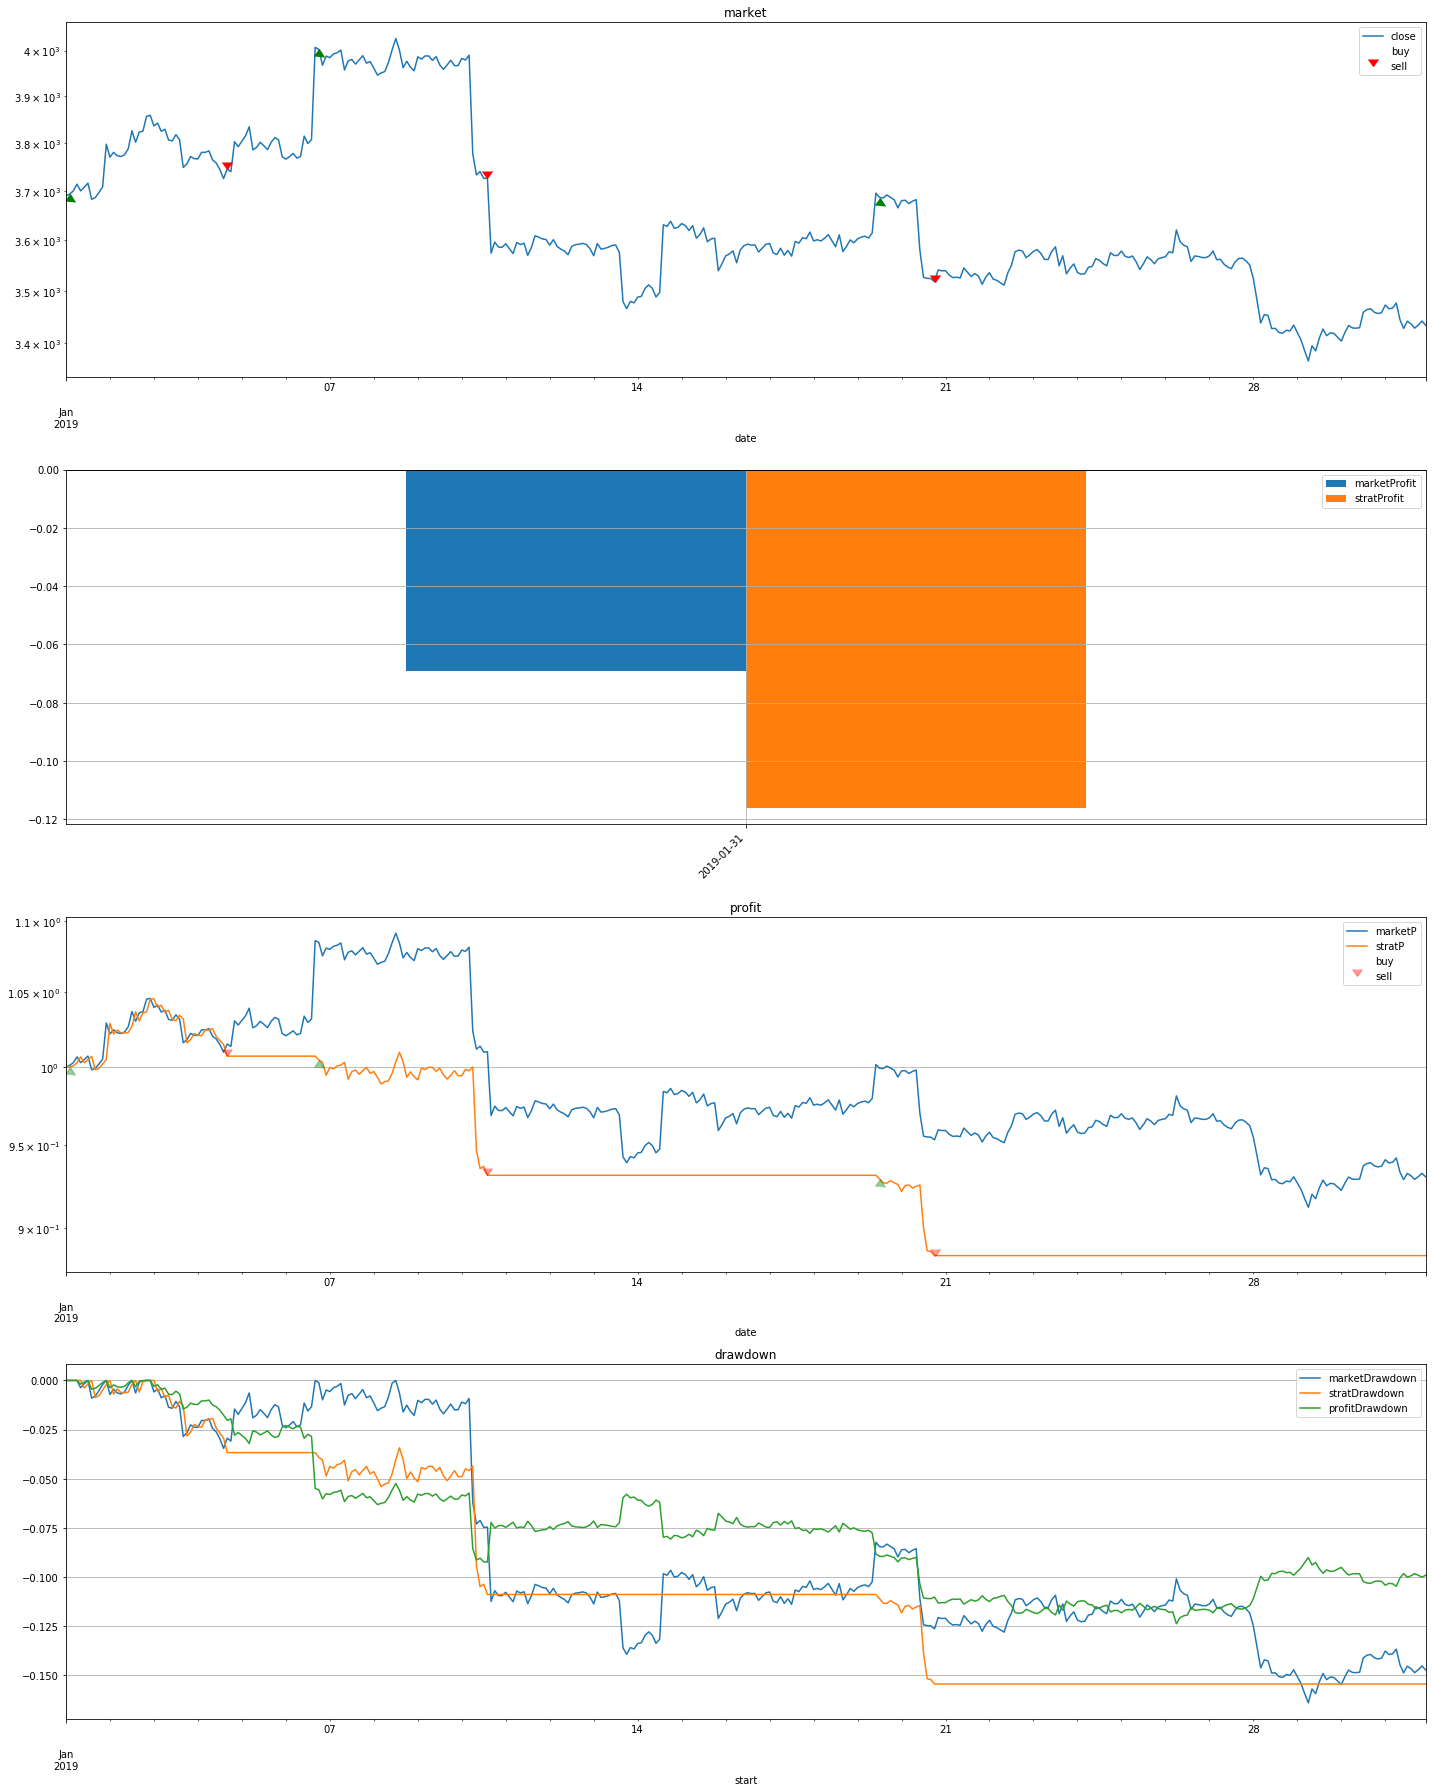

In [8]:
yant_cfg = {
    "emaPeriod": 42,
    "atrPeriod": 10,
    "candleSize": 120,
    "historySize": 200,
    "enterPeriods": 16,
    "exitDonchian": 31,
    "entryDonchian": 76,
    "exitAtrFactor": 0,
    "exitPersistency": 3
}
bt_config = build_backtest_config(
    exchange='binance', 
    asset='BTC', 
    currency='USDT', 
    candlesize=120, 
    strategy='YANT', 
    strat_config=yant_cfg, 
    date_start='2019-01-01', 
    date_end='2019-02-01'
)

report, jdf, profit = backtest(bt_config)
plotStats(jdf, profit);